In [6]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [7]:
#!pip install db-dtypes
#!pip install --upgrade google-cloud-bigquery google-cloud-storage google-cloud-bigquery-storage

In [8]:
import google
print(google.__file__)

None


In [9]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='film-wizard-453315')

# BigQuery
from google.cloud import bigquery
from google.cloud import bigquery_storage
print("BigQuery Storage API is installed successfully!")
bigquery_client = bigquery.Client(project='film-wizard-453315')

print("Clients initialized successfully!")

BigQuery Storage API is installed successfully!
Clients initialized successfully!


## Import Scripts

In [592]:
client = bigquery_client

query = 'SELECT * FROM `film-wizard-453315.scripts_preproc.processed_scripts_full`'
script_df = client.query(query).to_dataframe()

In [593]:
import pandas as pd

In [594]:
# project_id = 'film-wizard-453315'  # GCP Project ID
# dataset_id = "scripts_preproc"  # dataset name
# table_id = 'processed_scripts_full'  # Replace with your table name
# client = bigquery_client
# script_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

In [595]:
script_df = script_df.drop_duplicates(subset=['URL']).reset_index(drop= True)
script_df.dtypes, script_df.isnull().sum()

(lower_title           object
 Title                 object
 URL                   object
 Script                object
 Clean_Script          object
 joy                  float64
 neutral              float64
 sadness              float64
 surprise             float64
 anger                float64
 disgust              float64
 fear                 float64
 sentiment_entropy    float64
 sentiment_std        float64
 hapax                  Int64
 fkgl                 float64
 fre                  float64
 smog                 float64
 fog                  float64
 word count             Int64
 TTR                  float64
 script_length          Int64
 mean_word_length     float64
 dtype: object,
 lower_title             0
 Title                   0
 URL                     0
 Script                  0
 Clean_Script            0
 joy                   927
 neutral               466
 sadness               227
 surprise              262
 anger                1152
 disgust              72

In [596]:
query = '''
SELECT title, overview, release_date, runtime, genre_1, genre_2, genre_3

FROM `film-wizard-453315.tmdb_metadata.movie_details`
'''

# Run the query and store the results in a DataFrame
tmdb_df = client.query(query).to_dataframe()

#preprocess
tmdb_df['release_year'] = tmdb_df['release_date'].astype(str).str[:4]
tmdb_df['lower_title'] = tmdb_df['title'].apply(str.lower) + ' (' + tmdb_df['release_year'] + ')'

unique_genres = tmdb_df['genre_1'].unique().tolist()

In [597]:
len(unique_genres)

20

## Import TMDB


In [598]:
query = '''
SELECT tmdbId, title,  release_date, runtime, genre_1, genre_2, genre_3


FROM `film-wizard-453315.tmdb_metadata.movie_details`
'''

# Run the query and store the results in a DataFrame
tmdb_df = client.query(query).to_dataframe()

#preprocess
tmdb_df['release_year'] = tmdb_df['release_date'].astype(str).str[:4]
tmdb_df['lower_title'] = tmdb_df['title'].apply(str.lower) + ' (' + tmdb_df['release_year'] + ')'
tmdb_df['genres'] = tmdb_df['genre_1'].astype(str) + ' ' + tmdb_df['genre_2'].astype(str) + ' ' + tmdb_df['genre_3'].astype(str)
tmdb_df['genres'] = tmdb_df['genres'].str.replace('None', '').str.strip().apply(str.upper)
tmdb_df.drop(columns = ['genre_1','genre_2','genre_3','release_date'], inplace=True)
tmdb_df = tmdb_df.drop_duplicates(subset=['lower_title']).reset_index(drop= True)
# replace zero runtime with average
mean_runtime = tmdb_df[tmdb_df['runtime'] != 0]['runtime'].mean()
# Replace zeros with the calculated mean
tmdb_df['runtime'] = tmdb_df['runtime'].replace(0, mean_runtime)


tmdb_df

,tmdbId,title,runtime,release_year,lower_title,genres
0,2,Ariel,73.0,1988,ariel (1988),COMEDY DRAMA ROMANCE
1,3,Shadows in Paradise,74.0,1986,shadows in paradise (1986),COMEDY DRAMA ROMANCE
2,5,Four Rooms,98.0,1995,four rooms (1995),COMEDY
3,6,Judgment Night,109.0,1993,judgment night (1993),ACTION CRIME THRILLER
4,11,Star Wars,121.0,1977,star wars (1977),ADVENTURE ACTION SCIENCE FICTION
...,...,...,...,...,...,...
86138,1179468,Being Romanian: A Family Journal,95.0,2018,being romanian: a family journal (2018),DOCUMENTARY
86139,1181568,The Exorcists,85.0,2023,the exorcists (2023),HORROR THRILLER
86140,1181806,The Nurse That Saw the Baby on the Highway,49.0,2023,the nurse that saw the baby on the highway (2023),THRILLER
86141,1182286,Beneath Us All,91.0,2023,beneath us all (2023),HORROR


In [526]:
#merge dataframes 
df = pd.merge(script_df, tmdb_df, how = 'inner', on = 'lower_title')
#df = df.drop_duplicates(subset=['lower_title'])
df['words_per_minute'] = df['script_length'] / df['runtime']
df

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,tmdbId,title,runtime,release_year,genres,words_per_minute
0,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,72091,Voyage to the Prehistoric Planet,78.0,1965,SCIENCE FICTION ADVENTURE,63.935897
1,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",NaN,0.250000,0.035714,0.071429,NaN,...,488,0.160158,3047,3.692484,569499,Detainment,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667
2,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,833339,Speak No Evil,97.0,2022,HORROR THRILLER DRAMA,46.505155
3,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,44751,Dossier K.,120.0,2009,ACTION CRIME DRAMA,53.275
4,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,42202,Cyclone,118.0,1978,HORROR,41.152542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,11169,Spartan,102.0,2004,MYSTERY ACTION DRAMA,82.068627
19620,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,48918,Shadow of the Wolf,112.0,1992,ADVENTURE,29.125
19621,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,13184,Bangkok Dangerous,99.0,2008,ACTION CRIME THRILLER,20.333333
19622,slam dance (1987),Slam Dance (1987),/movie_script.php?movie=slam-dance,Great tune. That was\n a request from my mom.....,"[great, tune, that, was, a, request, from, my,...",0.024390,0.048780,0.170732,0.463415,0.097561,...,841,0.196817,4273,3.783758,78691,Slam Dance,99.0,1987,MYSTERY THRILLER CRIME,43.161616


In [527]:
df[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']] = df[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']].fillna(0)
df[['sentiment_entropy', 'sentiment_std']] = df[['sentiment_entropy', 'sentiment_std']].fillna(df[['sentiment_entropy', 'sentiment_std']].mean())
df = df.dropna()
df = df.drop_duplicates(subset=['lower_title'])
df.isnull().sum()
df

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,tmdbId,title,runtime,release_year,genres,words_per_minute
0,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,72091,Voyage to the Prehistoric Planet,78.0,1965,SCIENCE FICTION ADVENTURE,63.935897
1,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",0.000000,0.250000,0.035714,0.071429,0.000000,...,488,0.160158,3047,3.692484,569499,Detainment,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667
2,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,833339,Speak No Evil,97.0,2022,HORROR THRILLER DRAMA,46.505155
3,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,44751,Dossier K.,120.0,2009,ACTION CRIME DRAMA,53.275
4,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,42202,Cyclone,118.0,1978,HORROR,41.152542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,11169,Spartan,102.0,2004,MYSTERY ACTION DRAMA,82.068627
19620,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,48918,Shadow of the Wolf,112.0,1992,ADVENTURE,29.125
19621,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,13184,Bangkok Dangerous,99.0,2008,ACTION CRIME THRILLER,20.333333
19622,slam dance (1987),Slam Dance (1987),/movie_script.php?movie=slam-dance,Great tune. That was\n a request from my mom.....,"[great, tune, that, was, a, request, from, my,...",0.024390,0.048780,0.170732,0.463415,0.097561,...,841,0.196817,4273,3.783758,78691,Slam Dance,99.0,1987,MYSTERY THRILLER CRIME,43.161616


In [326]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re  # Import regular expression module

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Stopwords, Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing Function
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string values
        return ''
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize & Lowercase
    tokens = word_tokenize(text.lower())
    # Remove punctuation & stopwords
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df["clean_overview"] = df["overview"].apply(preprocess_text)

# Vectorize using CountVectorizer (Bag-of-Words Model)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(df["clean_overview"])
vocab = count_vectorizer.get_feature_names_out()

# Compute word frequencies
word_counts = X_bow.toarray().sum(axis=0)  # Sum word occurrences across all rows

# Identify words appearing more than 10 times
words_to_keep = [word for word, count in zip(vocab, word_counts) if count > 100]

# Refit CountVectorizer with filtered vocabulary
filtered_vectorizer = CountVectorizer(vocabulary=words_to_keep)
X_bow_filtered = filtered_vectorizer.fit_transform(df["clean_overview"])

# Convert to DataFrame and join with the original dataframe
vectorized_texts = pd.DataFrame(
    X_bow_filtered.toarray(),
    columns=filtered_vectorizer.get_feature_names_out(),
    index=df.index
)
vectorized_texts.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyError: 'overview'

In [327]:
from sklearn.feature_extraction.text import TfidfVectorizer
def preprocess_genres(genres):
    # Tokenize the genres (in this case, it's a simple space-separated string)
    genres = genres.lower()  # Convert to lowercase
    genres = genres.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return ' '.join(word_tokenize(genres))  # Tokenize and rejoin into a string

df['clean_genres'] = df['genres'].apply(preprocess_genres)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply the vectorizer to the cleaned genres column
tfidf_matrix = vectorizer.fit_transform(df['clean_genres'])

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()+'_genre', index = df.index)

# Display the resulting DataFrame of genre embeddings
df_combined = pd.concat([df, vectorized_texts, tfidf_df], axis=1)
df_genre_only = pd.concat([df, tfidf_df], axis=1)

In [328]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [528]:
df = df_genre_only
features = df.drop(columns=df.select_dtypes(include='object').columns)

# Standardize the features for better clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



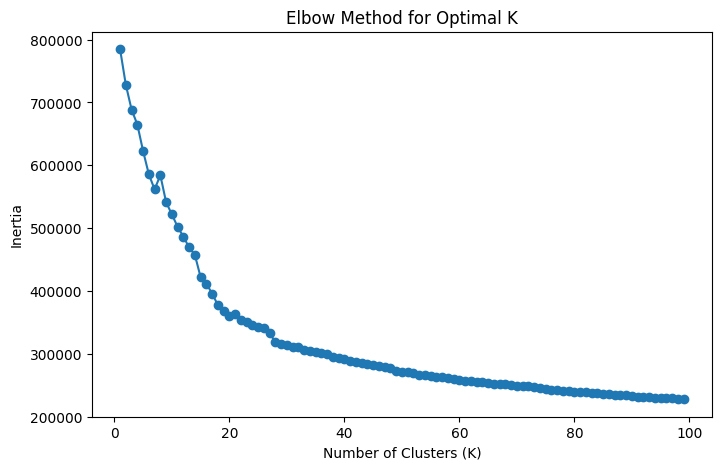

In [52]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 100)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [529]:
kmeans = KMeans(n_clusters=200, random_state=42)
df_genre_only['Cluster'] = kmeans.fit_predict(features_scaled)

# Show sample clustered data
df_genre_only[['Title', 'sadness', 'joy', 'Cluster', 'comedy_genre']].head()

,Title,sadness,joy,Cluster,comedy_genre
tmdbId,,,,,
72091,Voyage to the Prehistoric Planet (1965),0.080000,0.080000,9,0.0
569499,Detainment (2018),0.035714,0.000000,101,0.0
833339,Speak No Evil (2022),0.163265,0.306122,174,0.0
44751,Dossier K. (2009),0.078125,0.015625,165,0.0
42202,Cyclone (1978),0.156863,0.137255,109,0.0


In [349]:
df_genre_only[df_genre_only['Cluster']==856]

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,movie_genre,music_genre,mystery_genre,romance_genre,science_genre,thriller_genre,tv_genre,war_genre,western_genre,Cluster


In [530]:
film_string = 'Django Unchained (2012)' # Title (Year)


overview = df_combined[df_combined['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df_combined[df_combined['Cluster']==cluster][['Title','words_per_minute', 'anger']]


KeyError: "['Cluster'] not in index"

In [531]:
from sklearn.cluster import DBSCAN

df = df_genre_only
features = df.drop(columns=df.select_dtypes(include='object'))
features = features.drop(columns=['runtime'])

# Standardize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
df['Cluster'] = dbscan.fit_predict(features_scaled)
#features_scaled_df.describe().apply(lambda x: round(x,2))
print('Unclustered Films: ',len(df[df.Cluster == -1]))


Unclustered Films:  824


In [498]:
df['Cluster'].value_counts()




Cluster
-1    19624
Name: count, dtype: int64

In [430]:
film_string = 'Grown Ups (2010)' # Title (Year)
#film_string = 'Star Wars (1977)' # Title (Year)


overview = df[df['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df[df['Cluster']==cluster][['Title','sentiment_entropy','words_per_minute', 'genres']]

                  Title  Cluster
16506  Grown Ups (2010)       31


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_6473/3720343032.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


,Title,sentiment_entropy,words_per_minute,genres
58,Ali G Indahouse (2002),1.440430,101.0,COMEDY
87,Eddie Izzard: Definite Article (1996),1.411437,129.844037,COMEDY
93,Taylor Tomlinson: Quarter-Life Crisis (2020),1.151565,147.081967,COMEDY
110,Jim Jefferies: Fully Functional (2012),0.791615,135.916667,COMEDY
112,Nikki Glaser: Good Clean Filth (2022),1.193411,186.355932,COMEDY
...,...,...,...,...
19438,Waking Ned (1998),1.476908,88.736264,COMEDY
19515,Horrible Bosses 2 (2014),1.267117,161.611111,COMEDY
19539,Fighting with My Family (2019),1.566473,97.175926,COMEDY
19540,Out Cold (2001),1.456241,84.022472,COMEDY


In [499]:
df[df['Cluster']==9][['Title','sentiment_entropy','words_per_minute', 'genres']]

,Title,sentiment_entropy,words_per_minute,genres


In [432]:
df = df.drop(columns=['title'])

In [500]:
#Clusters in Pure Classes
df[df.comedy_genre == 1]['Cluster'].value_counts() #comedy all in one cluster
df[df.drama_genre == 1]['Cluster'].value_counts() #drama in 2 clusters
df[df.action_genre == 1]['Cluster'].value_counts() #action in one cluster
df[df.horror_genre == 1]['Cluster'].value_counts() #horror in one cluster
df[df.animation_genre == 1]['Cluster'].value_counts() #animation in one cluster

Cluster
-1    15
Name: count, dtype: int64

## PCA

In [591]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

df = pd.concat([df, tfidf_df], axis=1)
def script_classifier(sent_ent):
    if sent_ent > 1.4:
        return 2
    elif sent_ent > 1:
        return 1
    else:
        return 0 
    
df['sent_ent_class'] = df['sentiment_entropy'].apply(script_classifier)

#df.set_index('tmdbId', drop = True, inplace = True)
df.drop(columns = 'sentiment_entropy', inplace = True)
df
# features = df.drop(columns=df.select_dtypes(include='object'))
# features = features.drop(columns=['runtime'])

# # Standardize the genre features
# scaler = MinMaxScaler()
# script_columns = ['joy', 'neutral', 'sadness', 'surprise', 'anger', 'disgust', 'fear',
#        'sentiment_entropy', 'sentiment_std', 'hapax', 'fkgl', 'fre', 'smog',
#        'fog', 'word count', 'TTR', 'script_length', 'mean_word_length',
#        'words_per_minute']

# features_scaled = scaler.fit_transform(features)
# features_scaled_df = pd.DataFrame(features_scaled)
# features_scaled_df.columns = features.columns
# features_scaled_df[script_columns] = features_scaled_df[script_columns]*2

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.65, min_samples=6)  # Adjust eps and min_samples as needed
# df['Cluster'] = dbscan.fit_predict(features_scaled_df)
# pd.DataFrame(features_scaled_df).describe().apply(lambda x: round(x,2))
# print('Unclustered Films: ',len(df[df.Cluster == -1]))
# features_scaled_df

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [579]:
film_string = 'Grown Ups (2010)' # Title (Year)
#film_string = 'Star Wars (1977)' # Title (Year)


overview = df[df['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df[df['Cluster']==cluster][['Title','sentiment_entropy','sent_ent_class','words_per_minute', 'genres']]

                   Title  Cluster
tmdbId                           
38365   Grown Ups (2010)       18


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_6473/2020861060.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


,Title,sentiment_entropy,sent_ent_class,words_per_minute,genres
tmdbId,,,,,
9298,Ali G Indahouse (2002),1.440430,2,101.0,COMEDY
13588,Eddie Izzard: Definite Article (1996),1.411437,2,129.844037,COMEDY
671652,Taylor Tomlinson: Quarter-Life Crisis (2020),1.151565,1,147.081967,COMEDY
146837,Jim Jefferies: Fully Functional (2012),0.791615,0,135.916667,COMEDY
993703,Nikki Glaser: Good Clean Filth (2022),1.193411,1,186.355932,COMEDY
...,...,...,...,...,...
10162,Waking Ned (1998),1.476908,2,88.736264,COMEDY
227159,Horrible Bosses 2 (2014),1.267117,1,161.611111,COMEDY
445629,Fighting with My Family (2019),1.566473,2,97.175926,COMEDY


In [433]:
# BigQuery
# from google.cloud import bigquery, bigquery_storage
# bigquery_client = bigquery.Client(project='film-wizard-453315')

# proccessed_df = df

# project_id = 'film-wizard-453315'  # GCP Project ID
# dataset_id = "clustered_movies"  # dataset name

# table_id = "dbscan_all"  # Replace with your table name

# client = bigquery_client
# proccessed_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_6473/4028613545.py:13: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  proccessed_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")


KeyboardInterrupt: 

## No Genres



In [480]:
#merge dataframes 
df_script = pd.merge(script_df, tmdb_df, how = 'inner', on = 'lower_title')
df_script[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']] = df_script[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']].fillna(0)
df_script[['sentiment_entropy', 'sentiment_std']] = df_script[['sentiment_entropy', 'sentiment_std']].fillna(df_script[['sentiment_entropy', 'sentiment_std']].mean())
df_script = df_script.dropna()
df_script = df_script.drop_duplicates(subset=['lower_title'])
df_script['words_per_minute'] = df['script_length'] / df['runtime']
df_script.set_index('tmdbId', drop = True, inplace = True)
df_script2 = df_script.drop(columns=['word count','runtime','release_year','genres', 'title'])
df_script2

features2 = df_script2.drop(columns=df_script2.select_dtypes(include='object').columns)

# Standardize the features
scaler = MinMaxScaler()
features2_scaled = scaler.fit_transform(features2)
features2_scaled_df = pd.DataFrame(features2_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)  # Adjust eps and min_samples as needed
df_script['Cluster'] = dbscan.fit_predict(features2_scaled)
#features_scaled_df.describe().apply(lambda x: round(x,2))
print('Unclustered Films: ',len(df_script[df_script.Cluster == -1]))



Unclustered Films:  12425


In [481]:
df_script

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,title,runtime,release_year,genres,words_per_minute,Cluster
tmdbId,,,,,,,,,,,,,,,,,,,,,
72091,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,Voyage to the Prehistoric Planet,78.0,1965,SCIENCE FICTION ADVENTURE,63.935897,-1
569499,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",0.000000,0.250000,0.035714,0.071429,0.000000,...,488,0.160158,3047,3.692484,Detainment,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667,-1
833339,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,Speak No Evil,97.0,2022,HORROR THRILLER DRAMA,46.505155,0
44751,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,Dossier K.,120.0,2009,ACTION CRIME DRAMA,53.275,-1
42202,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,Cyclone,118.0,1978,HORROR,41.152542,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11169,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,Spartan,102.0,2004,MYSTERY ACTION DRAMA,82.068627,0
48918,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,Shadow of the Wolf,112.0,1992,ADVENTURE,29.125,-1
13184,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,Bangkok Dangerous,99.0,2008,ACTION CRIME THRILLER,20.333333,-1


In [569]:
df_script[df_script['Cluster']==1][['Title','sentiment_entropy','words_per_minute', 'genres']]
def script_classifier(sent_ent):
    if sent_ent > 1.4:
        return 2
    elif sent_ent > 1:
        return 1
    else:
        return 0 
df_script['sent_ent_class'] = df_script['sentiment_entropy'].apply(script_classifier)
df_script['sent_ent_class'].value_counts()


sent_ent_class
1    9557
2    8416
0    1651
Name: count, dtype: int64

In [570]:
df_script['Cluster'].value_counts()

Cluster
-1     12425
 0      6724
 51       19
 14       18
 7        15
       ...  
 40        2
 79        2
 66        2
 8         2
 73        1
Name: count, Length: 86, dtype: int64